# MegaFon Uplift Competition

https://ods.ai/competitions/megafon-df21-comp

In [1]:
import sys

!{sys.executable} -m pip install scikit-uplift dill lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklift.datasets import fetch_megafon
from sklift.models import TwoModels
from sklift.metrics import qini_auc_score
from sklift.viz import plot_qini_curve


%matplotlib inline
seed=31

## Load Data

In [3]:
dataset = fetch_megafon()

print(f"Dataset type: {type(dataset)}\n")
print(f"Dataset features shape: {dataset.data.shape}")
print(f"Dataset target shape: {dataset.target.shape}")
print(f"Dataset treatment shape: {dataset.treatment.shape}")

  0%|          | 0.00/276M [00:00<?, ?iB/s]

Dataset type: <class 'sklearn.utils.Bunch'>

Dataset features shape: (600000, 50)
Dataset target shape: (600000,)
Dataset treatment shape: (600000,)


## EDA

In [11]:
dataset.data.head().append(dataset.data.tail())

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50
0,39.396577,-0.186548,19.524505,21.250208,55.291264,182.966712,-5.385606,144.573379,-12.534344,-58.279429,...,90.877638,134.363458,-213.584582,-2.092461,-93.973258,-0.155597,-312.130733,44.798182,-125.682413,16.231365
1,38.987694,0.819522,-42.064512,-48.270949,-33.171257,179.459341,-87.151810,-162.693257,20.651652,181.635081,...,-183.840746,72.864779,559.783584,1.142391,80.037124,-1.216185,-111.473936,-127.737977,-117.501171,10.732234
2,-16.693093,1.844558,-8.615192,-18.818740,-22.271188,-116.290369,-63.816746,-38.340763,24.968496,-136.340629,...,-203.637766,2.480242,96.998504,1.100962,-33.275159,0.920926,-679.492242,-91.009397,-18.173358,14.367636
3,-72.040154,-0.226921,39.802607,16.441262,-1.112509,68.128008,23.073147,4.688858,-49.383641,-91.866107,...,172.906875,83.951551,-323.642557,-0.369182,93.221948,-1.962380,-442.466684,-22.298302,-75.916603,11.634299
4,18.296973,0.996437,24.465307,-34.151971,24.623458,-155.455558,-12.159787,26.705778,105.864805,258.607252,...,125.577535,-208.531112,118.902324,-0.808578,-117.497906,1.770635,627.395611,122.019189,194.091195,-11.883858
599995,33.031482,0.584463,-25.546737,-35.129322,6.603716,-90.384229,-44.399223,71.343628,26.439937,125.557722,...,-183.820274,-167.259176,531.793092,-2.307605,-48.648490,0.763070,152.501250,-49.190995,149.292732,-15.031430
599996,-24.469552,1.175070,35.936859,19.577711,81.505532,-164.141125,-8.221423,38.864814,-2.410108,71.748724,...,103.792521,-87.706751,-230.298393,0.267790,-56.102467,-1.007702,-69.854583,187.924882,109.642972,25.022399
599997,-57.592800,1.033326,-20.608920,87.116236,-27.894756,120.864975,40.592090,-34.134983,-26.821810,-236.479871,...,-97.993743,170.942462,299.211339,-0.930181,168.767350,-0.004762,-249.073528,-265.077308,-110.317964,-11.892925
599998,-16.371510,-0.876885,-1.483559,32.407631,-57.148865,92.559125,-21.464004,-110.615734,58.100487,-131.522851,...,-17.409713,108.897052,223.509177,-0.832695,5.545312,0.659149,-156.605507,-41.757924,-89.330302,-22.886739
599999,62.997565,-1.299755,-9.485073,4.682186,64.339233,-14.527508,-113.750106,195.634148,104.627105,-258.377735,...,-64.312678,48.114939,-231.497127,-0.022551,7.373350,0.213328,-235.624729,39.129831,-47.422068,-21.564626


In [ ]:
dataset.data.describe()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50
count,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,...,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000
mean,-3.758503,0.000405,0.356208,-1.004378,3.376919,-6.396371,-2.253712,-6.432606,-0.061507,-1.659301,...,6.882868,-6.632834,8.454493,0.001296,0.007967,-0.000966,-22.259600,-5.759041,6.241130,-1.176456
std,54.881882,0.999419,31.804123,45.291429,53.397644,140.873734,59.810396,74.840857,44.912292,199.625148,...,163.776538,137.025868,262.840194,1.000368,71.553713,0.999902,500.900364,130.952113,141.211999,21.363662
min,-271.659497,-4.372119,-148.870768,-244.446728,-302.574049,-683.126343,-322.731683,-506.202937,-218.466369,-920.347783,...,-810.842593,-633.575178,-1345.838757,-4.756720,-360.713742,-4.516004,-2506.960013,-687.526201,-702.184241,-98.094323
25%,-40.693313,-0.673108,-20.758308,-30.644608,-31.865404,-100.762161,-42.313674,-54.840796,-30.327330,-134.565241,...,-102.658380,-99.033996,-167.634846,-0.673780,-48.250836,-0.675549,-357.547278,-93.163915,-88.803657,-15.580688
50%,-3.954771,0.000915,0.372583,-0.585368,3.720738,-6.357443,-2.263690,-6.416419,-0.103742,-1.628897,...,7.190600,-6.784760,8.773280,0.001639,0.045537,-0.002251,-20.695017,-5.774627,6.286783,-1.199895
75%,33.174835,0.673056,21.495530,29.027860,38.988940,88.159514,37.709780,41.962767,30.144501,130.948487,...,116.755600,85.621324,185.382370,0.675779,48.221733,0.673638,313.295748,81.636824,101.558007,13.230410
max,250.812280,5.062006,170.053291,235.095937,284.915947,656.482242,293.909622,550.525780,219.628423,1251.776972,...,867.086690,689.626208,1488.759454,4.727996,384.665348,5.086304,2534.503855,595.321844,630.727101,112.233293


In [ ]:
dataset.treatment.value_counts()

treatment    300368
control      299632
Name: treatment_group, dtype: int64

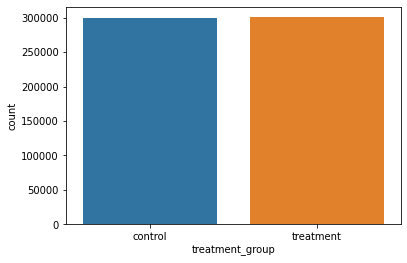

In [ ]:
sns.countplot(x=dataset.treatment)

In [ ]:
dataset.target.value_counts()

0    477486
1    122514
Name: conversion, dtype: int64

In [ ]:
pd.crosstab(dataset.treatment, dataset.target, normalize='index')

conversion,0,1
treatment_group,,
control,0.820600,0.179400
treatment,0.771081,0.228919


In [4]:
combined_df = pd.concat([dataset.data, dataset.treatment, dataset.target], axis=1)
combined_df["treatment_group"] = combined_df["treatment_group"].map({
    'control': 0, 
    'treatment': 1
})
print(combined_df.shape)

combined_df.head()

(600000, 52)


,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,treatment_group,conversion
0,39.396577,-0.186548,19.524505,21.250208,55.291264,182.966712,-5.385606,144.573379,-12.534344,-58.279429,...,-213.584582,-2.092461,-93.973258,-0.155597,-312.130733,44.798182,-125.682413,16.231365,0,0
1,38.987694,0.819522,-42.064512,-48.270949,-33.171257,179.459341,-87.151810,-162.693257,20.651652,181.635081,...,559.783584,1.142391,80.037124,-1.216185,-111.473936,-127.737977,-117.501171,10.732234,0,0
2,-16.693093,1.844558,-8.615192,-18.818740,-22.271188,-116.290369,-63.816746,-38.340763,24.968496,-136.340629,...,96.998504,1.100962,-33.275159,0.920926,-679.492242,-91.009397,-18.173358,14.367636,1,0
3,-72.040154,-0.226921,39.802607,16.441262,-1.112509,68.128008,23.073147,4.688858,-49.383641,-91.866107,...,-323.642557,-0.369182,93.221948,-1.962380,-442.466684,-22.298302,-75.916603,11.634299,1,0
4,18.296973,0.996437,24.465307,-34.151971,24.623458,-155.455558,-12.159787,26.705778,105.864805,258.607252,...,118.902324,-0.808578,-117.497906,1.770635,627.395611,122.019189,194.091195,-11.883858,1,0


In [13]:
control_group_df = combined_df[combined_df["treatment_group"] == 0].drop(columns=["treatment_group"])
control_group_df.head()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,conversion
0,39.396577,-0.186548,19.524505,21.250208,55.291264,182.966712,-5.385606,144.573379,-12.534344,-58.279429,...,134.363458,-213.584582,-2.092461,-93.973258,-0.155597,-312.130733,44.798182,-125.682413,16.231365,0
1,38.987694,0.819522,-42.064512,-48.270949,-33.171257,179.459341,-87.151810,-162.693257,20.651652,181.635081,...,72.864779,559.783584,1.142391,80.037124,-1.216185,-111.473936,-127.737977,-117.501171,10.732234,0
5,-0.639530,0.083205,11.722866,-22.561569,-29.253712,114.960502,-11.015233,-111.759927,35.970304,-169.279977,...,-78.493347,4.764657,1.553896,11.011644,0.183690,262.560479,25.105122,65.048061,9.091517,0
6,106.814864,2.475957,11.873446,-3.772046,-48.777730,-168.361553,-73.668159,37.530547,29.814252,334.968451,...,-205.579911,128.406136,-0.137143,-147.195159,-1.045413,702.311408,103.131298,216.015709,6.085234,0
11,44.900843,0.460697,-19.100158,-7.495167,34.775307,-52.026493,-9.564606,8.483533,9.300702,-298.281383,...,-83.916280,-79.179886,1.125676,-218.839386,-0.966154,-1006.730696,-220.940659,83.261530,-12.291804,0


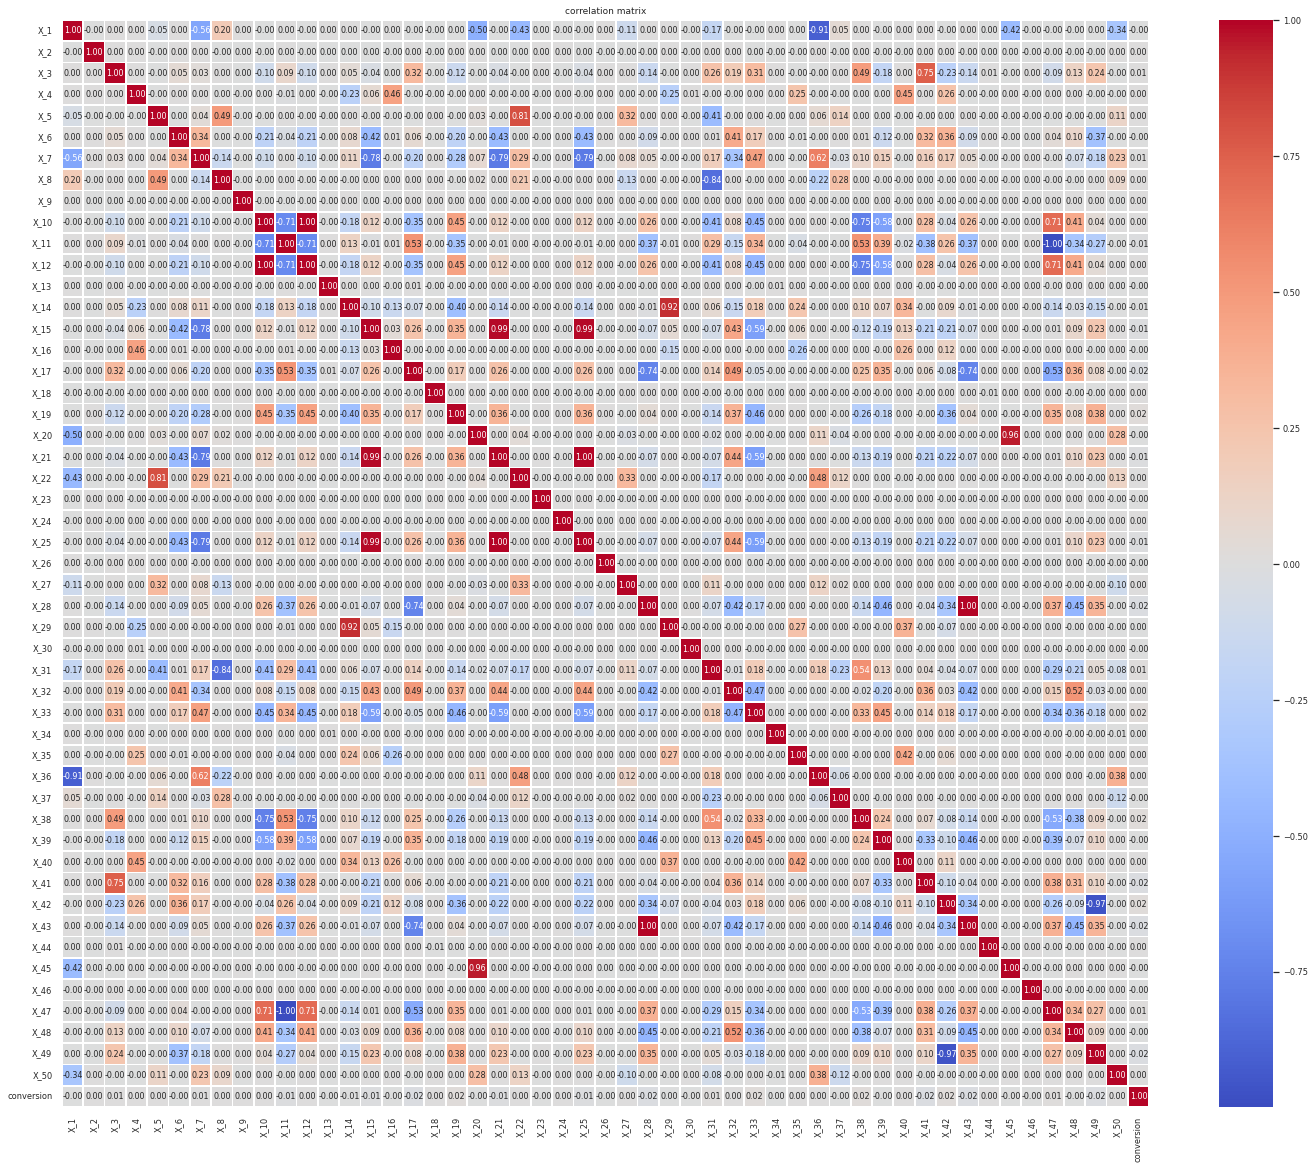

In [ ]:
# correlation of features
plt.figure(figsize = (25, 20))
sns.set(font_scale=0.75)
sns.heatmap(control_group_df.corr().round(3), annot=True, square = True, \
    linewidths=.75, cmap="coolwarm", fmt = ".2f", annot_kws = {"size": 8} )
plt.title("correlation matrix")
plt.show()

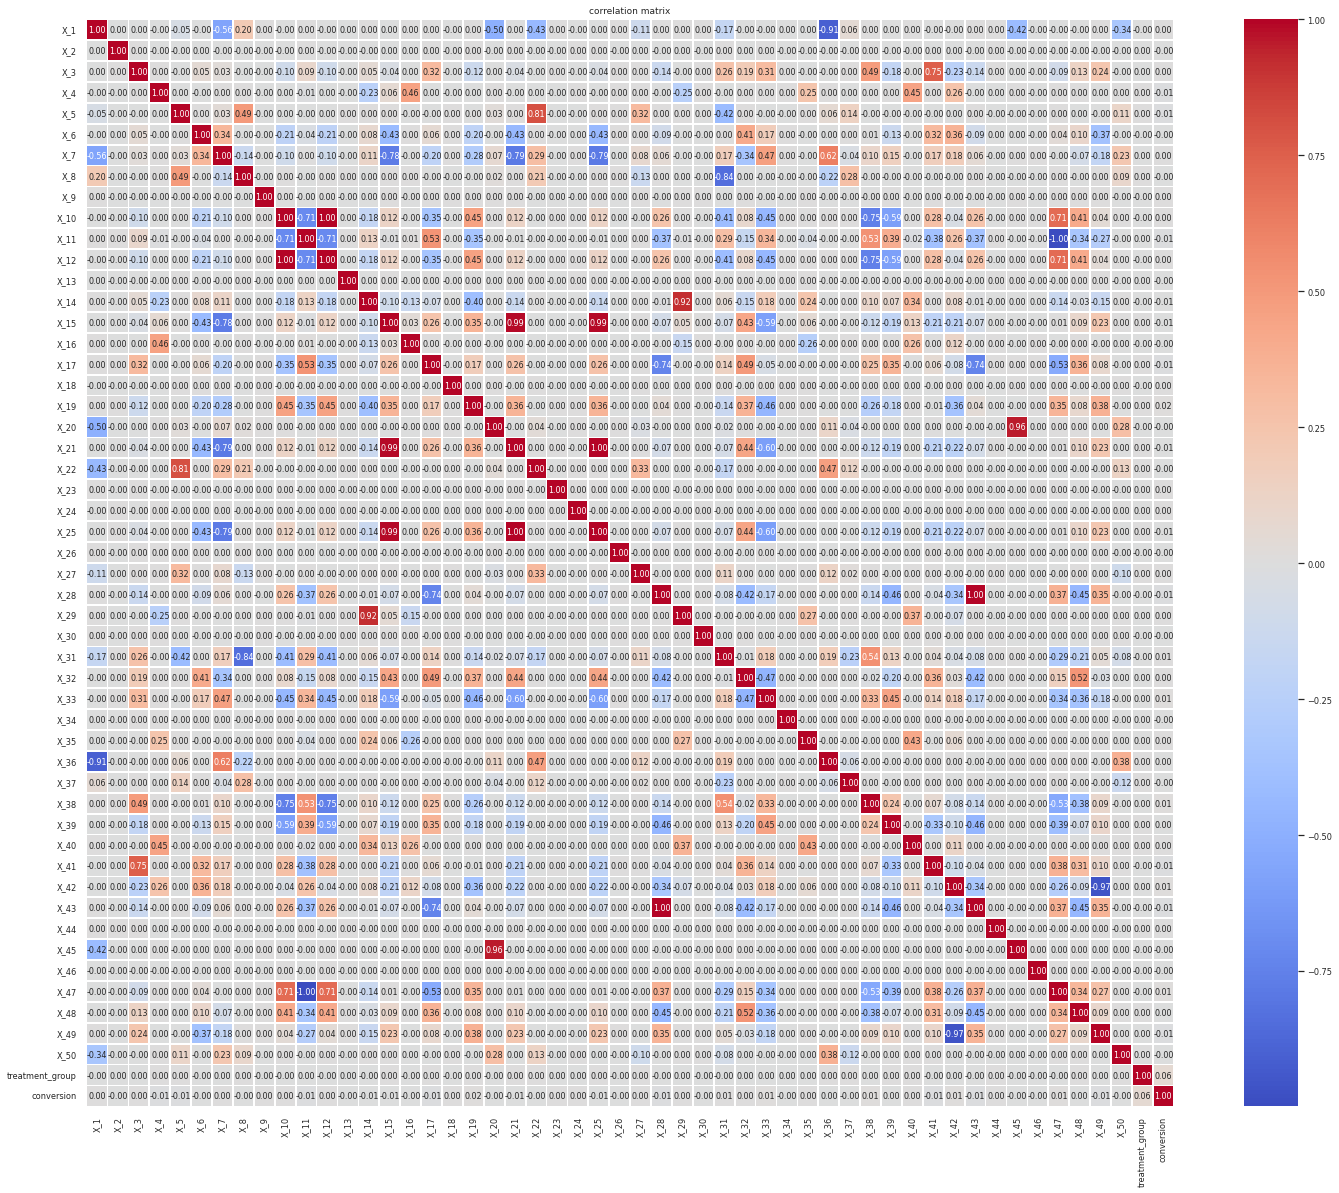

In [14]:
# correlation of features
plt.figure(figsize = (25, 20))
sns.set(font_scale=0.75)
sns.heatmap(combined_df.corr().round(3), annot=True, square = True, \
    linewidths=.75, cmap="coolwarm", fmt = ".2f", annot_kws = {"size": 8} )
plt.title("correlation matrix")
plt.show()

* It can be observed that all the 50 features are weakly correlated with conversion.
* The correlation coefficient between treatment and conversion is 0.06.

In [15]:
combined_df.corr().round(3)

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,treatment_group,conversion
X_1,1.000,0.000,0.000,-0.001,-0.050,-0.001,-0.562,0.204,0.001,-0.001,...,0.002,0.001,-0.418,-0.001,-0.002,-0.003,0.002,-0.342,-0.001,0.001
X_2,0.000,1.000,0.001,-0.000,-0.000,0.000,-0.001,-0.000,-0.001,-0.001,...,-0.001,0.001,-0.000,-0.000,-0.001,-0.002,-0.001,-0.001,0.000,-0.001
X_3,0.000,0.001,1.000,0.002,-0.002,0.051,0.029,-0.001,-0.000,-0.098,...,-0.136,0.002,0.000,-0.001,-0.092,0.128,0.241,-0.000,0.000,0.002
X_4,-0.001,-0.000,0.002,1.000,0.000,-0.000,0.001,0.001,-0.001,0.000,...,-0.001,0.000,0.001,-0.001,0.001,0.001,0.000,0.001,0.001,-0.008
X_5,-0.050,-0.000,-0.002,0.000,1.000,0.001,0.034,0.494,-0.001,0.000,...,0.001,-0.000,-0.003,-0.001,0.001,0.000,-0.000,0.108,0.002,-0.008
X_6,-0.001,0.000,0.051,-0.000,0.001,1.000,0.337,-0.000,-0.000,-0.213,...,-0.092,0.000,0.000,-0.001,0.039,0.101,-0.372,-0.001,-0.001,-0.001
X_7,-0.562,-0.001,0.029,0.001,0.034,0.337,1.000,-0.139,-0.001,-0.095,...,0.055,-0.001,0.001,0.001,-0.004,-0.073,-0.182,0.232,0.000,0.004
X_8,0.204,-0.000,-0.001,0.001,0.494,-0.000,-0.139,1.000,-0.001,0.001,...,0.002,-0.001,-0.004,-0.000,0.001,-0.001,0.001,0.088,0.001,-0.001
X_9,0.001,-0.001,-0.000,-0.001,-0.001,-0.000,-0.001,-0.001,1.000,0.001,...,-0.002,-0.000,0.001,-0.000,0.002,0.001,0.001,-0.000,-0.002,0.002
X_10,-0.001,-0.001,-0.098,0.000,0.000,-0.213,-0.095,0.001,0.001,1.000,...,0.256,-0.001,0.001,0.002,0.711,0.413,0.044,0.003,-0.000,0.004


## Simulate Spending

In [23]:
trmnt_group_converted = combined_df[(combined_df["treatment_group"] == 1) & (combined_df["conversion"] == 1)]
ctrl_group_converted = combined_df[(combined_df["treatment_group"] == 0) & (combined_df["conversion"] == 1)]
non_converted = combined_df[combined_df["conversion"] == 0]

print(trmnt_group_converted.shape)
print(ctrl_group_converted.shape)
print(non_converted.shape)

(68760, 52)
(53754, 52)
(477486, 52)


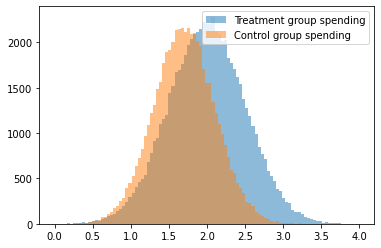

In [24]:
import numpy as np


# Create a noisy spending data for the treatment group
np.random.seed(42)
trmnt_group_spending = np.random.normal(2, 0.5, len(trmnt_group_converted))
ctrl_group_spending = np.random.normal(1.7, 0.4, len(ctrl_group_converted))


bins = np.linspace(0, 4, 100)
plt.hist(trmnt_group_spending, bins, alpha=0.5, label='Treatment group spending')
plt.hist(ctrl_group_spending, bins, alpha=0.5, label='Control group spending')
plt.legend(loc='upper right')
plt.show()

In [25]:
trmnt_group_spending.shape, ctrl_group_spending.shape

((68760,), (53754,))

In [26]:
trmnt_group_converted["spending"] = trmnt_group_spending
ctrl_group_converted["spending"] = ctrl_group_spending
non_converted["spending"] = 0

combined_df_with_spending = pd.concat([trmnt_group_converted, ctrl_group_converted, non_converted])
print(combined_df_with_spending.shape)

combined_df_with_spending.head()

(600000, 53)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_44,X_45,X_46,X_47,X_48,X_49,X_50,treatment_group,conversion,spending
20,-66.700613,-0.579581,53.838094,25.125590,6.743822,-8.751333,88.423510,-18.628297,104.642760,-130.664072,...,-1.367072,4.602121,-0.701179,-153.587504,-18.442791,-50.597738,-8.983202,1,1,2.248357
21,-11.512303,1.287760,-29.249913,-57.810113,11.730489,-326.999106,-48.039201,-305.065456,42.028536,298.844066,...,0.767403,16.663241,0.252728,-304.312779,75.268100,193.895515,1.386769,1,1,1.930868
41,-22.128035,-0.687876,-50.717555,-58.895313,50.794898,-26.065448,50.189709,-18.568091,-3.744784,-226.544974,...,-0.803531,-119.757905,-0.236279,-708.708863,181.176921,-89.133027,49.941668,1,1,2.323844
58,-75.898294,0.309707,-12.084663,35.887178,67.907062,-38.705282,27.283067,99.135893,31.750946,158.596495,...,-0.119334,85.093724,0.488970,31.481788,88.314766,-46.519348,30.214437,1,1,2.761515
60,29.192624,-1.376180,44.365112,68.403800,-41.818524,22.317416,0.086787,-100.219033,26.132823,416.413998,...,1.026432,-54.872579,-0.283652,1081.831614,205.656049,153.551092,13.986240,1,1,1.882923


## Baseline Model

In [28]:
combined_df_with_spending["treatment_group"].value_counts()

1    300368
0    299632
Name: treatment_group, dtype: int64

In [29]:
feature_cols = [col for col in combined_df_with_spending.columns if col.startswith("X_")]
print(f"Number of features: {len(feature_cols)}")

Number of features: 50


In [30]:
# Shuffle the data
full_data = combined_df_with_spending.sample(frac=1, random_state=42)
print(full_data.shape)

full_data.head()

(600000, 53)


,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_44,X_45,X_46,X_47,X_48,X_49,X_50,treatment_group,conversion,spending
37241,30.391239,0.135635,-38.570025,49.263597,120.389644,-102.594615,-1.361772,83.559162,82.942751,258.863139,...,-1.230521,14.412261,-0.561299,708.670138,-197.715413,-53.933253,-14.364639,1,1,1.705054
529683,77.689423,1.215384,32.574152,-49.665542,15.220808,116.231168,37.602069,14.854413,-50.319782,90.566993,...,-1.167994,-140.364986,1.286426,-91.062756,-76.050655,-214.198314,-33.071350,1,1,2.042406
339581,19.176133,-1.353427,-27.029853,77.017433,34.941023,99.308737,69.612477,-74.093750,-34.120708,235.142052,...,-0.517577,-25.496290,0.598395,-148.576784,62.919702,-124.503096,19.781948,0,0,0.000000
363488,-73.359977,0.910815,17.594132,-35.772728,20.484921,-78.936500,78.588632,64.824181,23.802910,94.292610,...,0.522036,76.699273,-2.716671,-366.043860,74.837081,-15.626338,21.535789,1,1,1.135101
429306,-93.580934,-0.033293,-32.532419,-4.021167,-58.597782,22.771683,79.381321,-93.265539,17.567098,-145.748250,...,1.241179,36.094642,0.400099,-418.849066,-8.175022,-56.106051,6.096248,0,0,0.000000


In [31]:
stratify_cols = full_data[["treatment_group", "conversion"]]

X_train, X_val, trmnt_train, trmnt_val, y_train, y_val, spending_train, spending_val = train_test_split(
    full_data[feature_cols],
    full_data["treatment_group"],
    full_data["conversion"],
    full_data["spending"],
    stratify=stratify_cols,
    test_size=0.3,
    random_state=31
)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")

Train shape: (420000, 50)
Validation shape: (180000, 50)


In [32]:
treatment_model = lgb.LGBMClassifier(random_state=31)
control_model = lgb.LGBMClassifier(random_state=31)
tm = TwoModels(estimator_trmnt = treatment_model, estimator_ctrl = control_model, method='vanilla')

In [33]:
%%time
tm = tm.fit(X_train, y_train, trmnt_train)

CPU times: user 29.7 s, sys: 73.2 ms, total: 29.8 s
Wall time: 15.8 s


In [34]:
uplift_tm = tm.predict(X_val)

auqc = qini_auc_score(y_val, uplift_tm, trmnt_val) 
print(f"Qini coefficient on validation data: {auqc:.4f}")

Qini coefficient on validation data: 0.2362


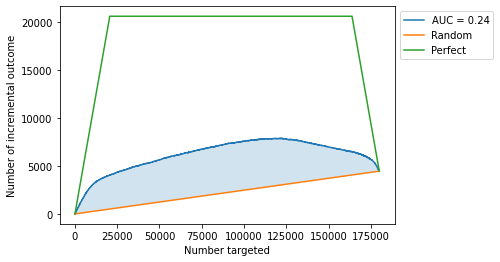

In [35]:
plot_qini_curve(y_val, uplift_tm, trmnt_val, perfect=True);

In [36]:
from sklift.metrics import (
    uplift_at_k,
    uplift_by_percentile,
    weighted_average_uplift,
    qini_auc_score,
    uplift_auc_score
)
from sklift.models import (
    ClassTransformation,
    SoloModel,
    TwoModels
)
from sklift.viz import (
    plot_uplift_by_percentile,
    plot_uplift_preds,
    plot_qini_curve,
    plot_uplift_curve
)

In [37]:
uplift_ct_avg = weighted_average_uplift(y_val, uplift_tm, trmnt_val, bins=10) 
print(f"average uplift: {uplift_ct_avg:.4f}")

pd.options.display.float_format = '{:,.3f}'.format
uplift_by_percentile(
    y_val, 
    uplift_tm, 
    trmnt_val, 
    strategy="overall", total=True, std=True, bins=10
)

average uplift: 0.0495


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,8949,9051,0.567,0.136,0.431,0.005,0.004,0.006
10-20,8905,9095,0.244,0.120,0.125,0.005,0.003,0.006
20-30,9017,8983,0.214,0.114,0.100,0.004,0.003,0.005
30-40,8969,9031,0.203,0.118,0.085,0.004,0.003,0.005
40-50,9099,8901,0.200,0.123,0.077,0.004,0.003,0.005
50-60,9017,8983,0.187,0.139,0.047,0.004,0.004,0.005
60-70,9018,8982,0.170,0.169,0.001,0.004,0.004,0.006
70-80,9033,8967,0.097,0.159,-0.063,0.003,0.004,0.005
80-90,9097,8903,0.094,0.168,-0.073,0.003,0.004,0.005


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


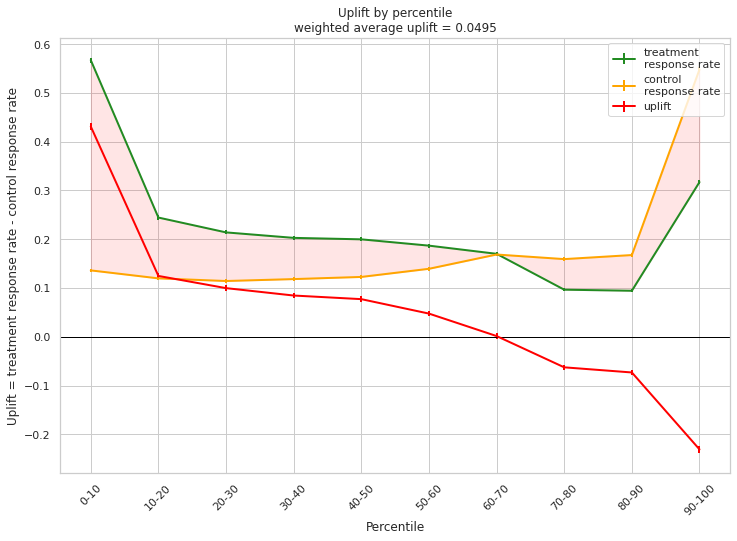

In [38]:
%matplotlib inline
plt.style.use('bmh')
sns.set_theme(style="whitegrid")

plot_uplift_by_percentile(y_val, uplift_tm, trmnt_val, strategy="overall", kind="line");
fig = plt.gcf()
fig.set_size_inches(12, 8)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


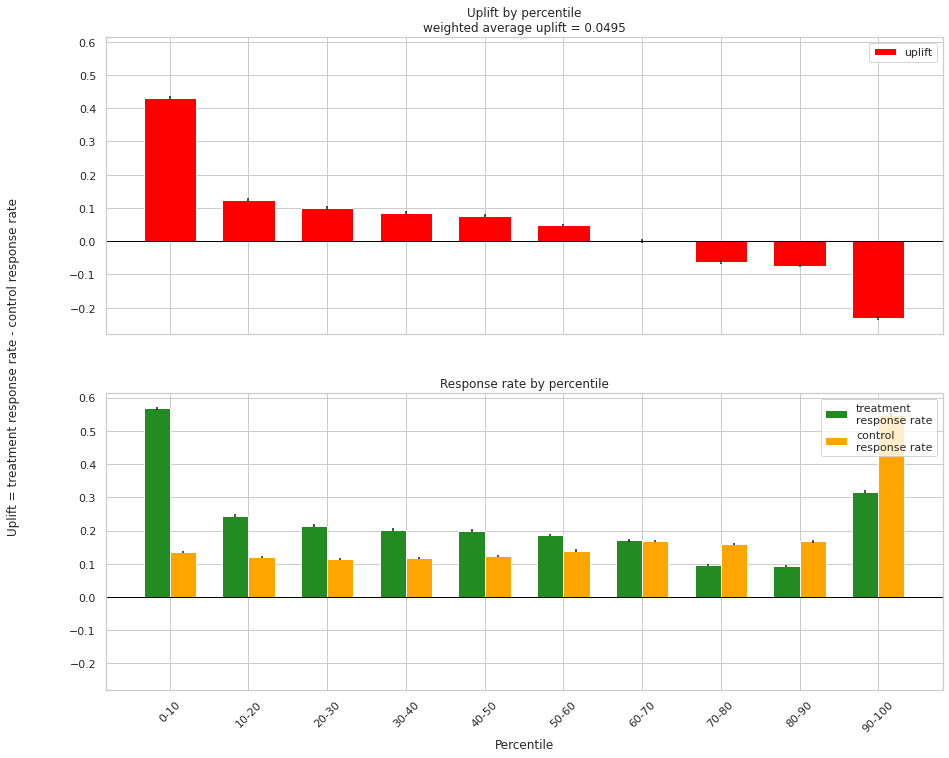

In [39]:
plot_uplift_by_percentile(y_val, uplift_tm, trmnt_val, strategy="overall", kind="bar");
fig = plt.gcf()
fig.set_size_inches(15, 12)

Qini coefficient: 0.236
Uplift auc score: 0.164


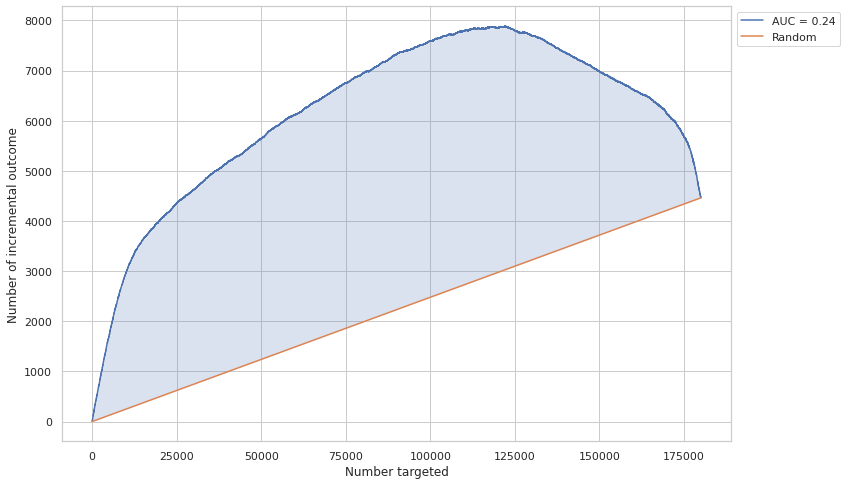

In [40]:
# AUQC = area under Qini curve = Qini coefficient
auqc = qini_auc_score(y_val, uplift_tm, trmnt_val) 
print(f"Qini coefficient: {auqc:.3f}")

auuc = uplift_auc_score(y_val, uplift_tm, trmnt_val) 
print(f"Uplift auc score: {auuc:.3f}")

# qini curve
plot_qini_curve(y_val, uplift_tm, trmnt_val, perfect=False);
fig = plt.gcf()
fig.set_size_inches(12, 8)

## Cost Efficiency Estimation

In [44]:
val_group = pd.DataFrame(
    np.array([trmnt_val, y_val, uplift_tm, spending_val]).T,
    columns=["treatment_group", "conversion", "uplift_score", "spending"]
)
val_group["treatment_group"] = val_group["treatment_group"].astype(int)
val_group["conversion"] = val_group["conversion"].astype(int)
print(val_group.shape)

val_group.head()

(180000, 4)


,treatment_group,conversion,uplift_score,spending
0,1,1,0.068,1.807
1,1,0,0.158,0.000
2,0,0,0.181,0.000
3,0,0,0.175,0.000
4,0,0,-0.031,0.000


In [45]:
val_group["treatment_group"].value_counts()

1    90110
0    89890
Name: treatment_group, dtype: int64

In [47]:
group_cvr = pd.crosstab(val_group["treatment_group"], val_group["conversion"], normalize='index')
group_cvr

conversion,0,1
treatment_group,,
0,0.821,0.179
1,0.771,0.229


In [48]:
ctrl_group_cvr = group_cvr.loc[0].loc[1]
trmnt_group_cvr = group_cvr.loc[1].loc[1]

trmnt_group_cvr, ctrl_group_cvr

(0.2289202086338919, 0.17939704082767827)

In [53]:
agg_spending = val_group.groupby("treatment_group").agg({"spending": sum})
agg_spending

,spending
treatment_group,
0,"27,463.061"
1,"41,302.277"


In [55]:
ctrl_group_spending = agg_spending.loc[0].loc["spending"]
trmnt_group_spending = agg_spending.loc[1].loc["spending"]

trmnt_group_spending, ctrl_group_spending

(41302.27658000131, 27463.06110023757)

### Random targeting

In [56]:
trmnt_group_size, ctrl_group_size = val_group["treatment_group"].value_counts().values
trmnt_group_size, ctrl_group_size

(90110, 89890)

In [57]:
incr_trxn = ctrl_group_size * (trmnt_group_cvr - ctrl_group_cvr)
incr_spending = trmnt_group_spending / trmnt_group_size * ctrl_group_size - ctrl_group_spending

print(f"Number of incremental transactions: {int(incr_trxn)}")
print(f"Increment spending: {round(incr_spending, 3)}")

Number of incremental transactions: 4451
Increment spending: 13738.378


In [59]:
RATE = 0.1
CPIT = RATE * ctrl_group_size / incr_trxn
CPIG = RATE * ctrl_group_size / incr_spending

print(f"Cost per incremental transaction: {round(CPIT, 3)}")
print(f"Cost per incremental gain: {round(CPIG, 3)}")

Cost per incremental transaction: 2.019
Cost per incremental gain: 0.654
